In [826]:
import pickle
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.spatial.distance import cdist, cosine
from scipy.optimize import linear_sum_assignment
from skimage import measure
import random, math, sys
import numpy.matlib
import itertools
import time
from math import log
from scipy.interpolate import Rbf,InterpolatedUnivariateSpline,interp1d
from sklearn.model_selection import train_test_split
from sklearn import neighbors as nb
%matplotlib inline

In [873]:
## Constants
number_of_samples = 10
contours_level = 0.08
nbins_r=8
nbins_theta=12
r_inner=0.1250
r_outer=2.0

In [874]:
## Common Methods
def load_pkl(fname):
    with open(fname,'rb') as f:
        return pickle.load(f)

def save_pkl(fname,obj):
    with open(fname,'wb') as f:
        pickle.dump(obj,f)
        
def get_outliers(image, scale):
    contours = measure.find_contours(image, scale)
    contours_np = array(contours)
    outliers = []
    for contours_np_item in contours_np:
        for twod_item in contours_np_item:
            outliers.append(twod_item)
    outliers = np.asarray(outliers)
    # print(outliers.shape)
    return outliers

def get_samples(input_image):
    sampe_image_outliers = get_outliers(input_image, contours_level)
    split = np.array_split(sampe_image_outliers, number_of_samples)
    fiteredPointsTest = []
    for s in split:
        fiteredPointsTest.append(random.choice(s))
    fiteredPointsTest = np.asarray(fiteredPointsTest)
    return fiteredPointsTest

def sc_compute(points):
        """
          Here we are computing shape context descriptor
        """
        t_points = len(points) # say 5
        # getting euclidian distance
        r_array = cdist(points, points)
        # getting two points with maximum distance to norm angle by them
        # this is needed for rotation invariant feature
        am = r_array.argmax()
        max_points = [am / t_points, am % t_points]
        # normalizing
        r_array_n = r_array / r_array.mean()
        # create log space
        r_bin_edges = np.logspace(np.log10(r_inner), np.log10(r_outer), nbins_r)
        r_array_q = np.zeros((t_points, t_points), dtype=int)
        # summing occurences in different log space intervals
        # logspace = [0.1250, 0.2500, 0.5000, 1.0000, 2.0000]
        # 0    1.3 -> 1 0 -> 2 0 -> 3 0 -> 4 0 -> 5 1
        # 0.43  0     0 1    0 2    1 3    2 4    3 5
        for m in range(nbins_r):
            r_array_q += (r_array_n < r_bin_edges[m])
        fz = r_array_q > 0
        # getting angles in radians
        theta_array = cdist(points, points, lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
        # norm_angle = theta_array(max_points[0], max_points[1])
        # making angles matrix rotation invariant
        # theta_array = (theta_array - norm_angle * (np.ones((t_points, t_points)) - np.identity(t_points)))
        # removing all very small values because of float operation
        theta_array[np.abs(theta_array) < 1e-7] = 0
        # 2Pi shifted because we need angels in [0,2Pi]
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        # Simple Quantization
        theta_array_q = (1 + np.floor(theta_array_2 / (2 * math.pi / nbins_theta))).astype(int)
        # building point descriptor based on angle and distance
        nbins = nbins_theta * nbins_r
        descriptor = np.zeros((t_points, nbins))
        for i in range(t_points):
            sn = np.zeros((nbins_r, nbins_theta))
            for j in range(t_points):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            descriptor[i] = sn.reshape(nbins)
        return descriptor

def get_binary_histogram(points):
    sampe_image_outliers_samples_sd = sc_compute(points)
    return sampe_image_outliers_samples_sd

In [875]:
train_data = load_pkl('train_data.pkl')

for i in range (len(train_data)):
    for j in range (len(train_data[i])):
        for k in range (len(train_data[i][j])):
            if train_data[i][j][k] == False:
                train_data[i][j][k] = 0
            else:
                train_data[i][j][k] = 1
                    
train_data_np = np.empty((6400, 54, 54));
c=0;
        
for td in train_data:
    tdnp = np.asarray(td, dtype=np.float32)
    l = np.hstack((tdnp, np.zeros((tdnp.shape[0], (54 - tdnp.shape[1])), dtype = np.float32)))
    l = np.vstack((l, np.zeros((54 - l.shape[0], l.shape[1]), dtype = np.float32)))
    # l = l.flatten()
    train_data_np[c] = l
    c += 1
train_labels = np.load('finalLabelsTrain.npy')

for tl in train_labels:
    tl = np.asarray(tl, dtype=np.float32)

In [878]:
train_data_resized = np.empty((6400, 784));
c=0;
for train_data_np_item in train_data_np:
    image_resized = resize(train_data_np_item, (28, 28), anti_aliasing=True)
    train_data_resized[c] = image_resized.flatten()
    c += 1;

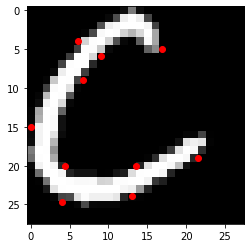

In [879]:
image1= train_data_resized[21].reshape(28,28)
points1 = get_samples(image1)
plt.imshow(image1, cmap='gray')
plt.scatter(x=points1[:,1], y=points1[:,0], c='r')
BH1 = get_binary_histogram(points1)

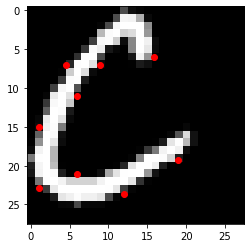

In [844]:
image2= train_data_resized[20].reshape(28,28)
points2 = get_samples(image2)
plt.imshow(image2, cmap='gray')
plt.scatter(x=points2[:,1], y=points2[:,0], c='r')
BH2 = get_binary_histogram(points2)

In [845]:
def diff(P,Q,qlength=None):
    """
        if Q is generalized shape context then it compute shape match.

        if Q is r point representative shape contexts and qlength set to 
        the number of points in Q then it compute fast shape match.

    """
    result = None
    C = cost(P,Q,qlength)
    return C

def cost(P,Q,qlength=None):
    p,_ = P.shape
    p2,_ = Q.shape
    d = p2
    if qlength:
        d = qlength
    C = np.zeros((p,p2))
    for i in range(p):
        for j in range(p2):
            C[i,j] = _cost(Q[j]/d,P[i]/p)    

    return C

def _cost(hi,hj):
    cost = 0
    for k in range(nbins_r):
        if (hi[k] + hj[k]):
            cost += ( (hi[k] - hj[k])**2 ) / ( hi[k] + hj[k] )

    return cost*0.5

In [846]:
cost_matrix = diff(BH1, BH2)

cost_matrix.shape

(9, 9)

In [847]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)
print(cost_matrix[row_ind, col_ind].sum())

0.47407407407407404


In [848]:
print(X_train.shape)

(1200, 784)


In [849]:
def get_points_Of_data_set(data_set):
    data_set_sample_points = []
    for image in data_set:
        image_points = get_samples(image.reshape(28, 28))
        data_set_sample_points.append(image_points)
    data_set_sample_points = np.asarray(data_set_sample_points)
    return data_set_sample_points

def get_binary_histogram_of_data_set(data_set_sample_points):
    data_set_binary_histogram = []
    for image_sample_points in data_set_sample_points:
        data_set_binary_histogram.append(sc_compute(image_sample_points))
    data_set_binary_histogram = np.asarray(data_set_binary_histogram)
    return data_set_binary_histogram

        

In [850]:
index = 0;
filtered_data = []
filtered_data_labels = []
for i in range (train_data_resized.shape[0]):
    if train_labels[i] == 1 or train_labels[i] == 2:
        filtered_data.append(train_data_resized[i]);
        filtered_data_labels.append(train_labels[i]);

filtered_data = np.array(filtered_data)
filtered_data_labels = np.array(filtered_data_labels)

print(train_data_resized.shape[0])
(X_train, X_test, y_train, y_test) = train_test_split(filtered_data, filtered_data_labels, test_size=.25)

train_sample_points = get_points_Of_data_set(X_train)
train_binay_histogram = get_binary_histogram_of_data_set(train_sample_points)


6400


In [851]:
test_sample_points = get_points_Of_data_set(X_test)
test_binay_histogram = get_binary_histogram_of_data_set(test_sample_points)

In [852]:
print(train_binay_histogram.shape)
print(test_binay_histogram.shape)

(1200, 9, 96)
(400, 9, 96)


In [800]:
cost_matrix = np.empty((test_binay_histogram.shape[0], train_binay_histogram.shape[0], number_of_samples, number_of_samples))
costTestVsTrain = np.empty((test_binay_histogram.shape[0],train_binay_histogram.shape[0]))
print(cost_matrix.shape)
error_count = 0;

for test_image_histogram_index in range (test_binay_histogram.shape[0]):
    BH1 = test_binay_histogram[test_image_histogram_index]
    for train_image_histogram_index in range (train_binay_histogram.shape[0]):
        BH2 = train_binay_histogram[train_image_histogram_index]
        currentCost = diff(BH1, BH2)
        row_ind, col_ind = linear_sum_assignment(currentCost)
        costTestVsTrain[test_image_histogram_index][train_image_histogram_index] = currentCost[row_ind, col_ind].sum()
        
    index = np.argmin(costTestVsTrain[test_image_histogram_index])
    print(index)
    true_label = y_test[test_image_histogram_index]
    pred_label = y_train[index]
    
    print((test_image_histogram_index+1), " : Acutal: ", true_label, " Predicted: ",  pred_label)
    if(true_label != pred_label):
        error_count += 1
        print("Total error: ", error_count)

print(cost_matrix.shape)

(400, 1200, 9, 9)
187
1  : Acutal:  1.0  Predicted:  1.0
796
2  : Acutal:  2.0  Predicted:  2.0
47
3  : Acutal:  1.0  Predicted:  2.0
Total error:  1
30
4  : Acutal:  1.0  Predicted:  1.0
691
5  : Acutal:  1.0  Predicted:  1.0
473
6  : Acutal:  1.0  Predicted:  1.0
636
7  : Acutal:  2.0  Predicted:  2.0
684
8  : Acutal:  1.0  Predicted:  1.0
541
9  : Acutal:  1.0  Predicted:  1.0
206
10  : Acutal:  2.0  Predicted:  2.0
88
11  : Acutal:  1.0  Predicted:  1.0
470
12  : Acutal:  2.0  Predicted:  2.0
204
13  : Acutal:  2.0  Predicted:  2.0
1135
14  : Acutal:  2.0  Predicted:  2.0
743
15  : Acutal:  2.0  Predicted:  2.0
208
16  : Acutal:  1.0  Predicted:  1.0
1037
17  : Acutal:  1.0  Predicted:  2.0
Total error:  2
1094
18  : Acutal:  1.0  Predicted:  1.0
1073
19  : Acutal:  2.0  Predicted:  2.0
801
20  : Acutal:  1.0  Predicted:  1.0
554
21  : Acutal:  1.0  Predicted:  1.0
169
22  : Acutal:  2.0  Predicted:  2.0
1147
23  : Acutal:  2.0  Predicted:  2.0
107
24  : Acutal:  2.0  Predicted:  1

1110
187  : Acutal:  2.0  Predicted:  2.0
1057
188  : Acutal:  2.0  Predicted:  2.0
1185
189  : Acutal:  2.0  Predicted:  2.0
1085
190  : Acutal:  2.0  Predicted:  2.0
564
191  : Acutal:  2.0  Predicted:  1.0
Total error:  42
1195
192  : Acutal:  2.0  Predicted:  2.0
200
193  : Acutal:  2.0  Predicted:  2.0
234
194  : Acutal:  2.0  Predicted:  2.0
93
195  : Acutal:  2.0  Predicted:  1.0
Total error:  43
75
196  : Acutal:  2.0  Predicted:  2.0
425
197  : Acutal:  1.0  Predicted:  1.0
282
198  : Acutal:  1.0  Predicted:  1.0
127
199  : Acutal:  1.0  Predicted:  2.0
Total error:  44
151
200  : Acutal:  2.0  Predicted:  2.0
687
201  : Acutal:  2.0  Predicted:  1.0
Total error:  45
238
202  : Acutal:  2.0  Predicted:  2.0
7
203  : Acutal:  1.0  Predicted:  2.0
Total error:  46
490
204  : Acutal:  2.0  Predicted:  2.0
449
205  : Acutal:  2.0  Predicted:  2.0
881
206  : Acutal:  2.0  Predicted:  2.0
684
207  : Acutal:  1.0  Predicted:  1.0
871
208  : Acutal:  2.0  Predicted:  2.0
863
209  : A

946
371  : Acutal:  2.0  Predicted:  2.0
55
372  : Acutal:  1.0  Predicted:  1.0
840
373  : Acutal:  2.0  Predicted:  2.0
1
374  : Acutal:  1.0  Predicted:  1.0
515
375  : Acutal:  2.0  Predicted:  2.0
428
376  : Acutal:  1.0  Predicted:  1.0
926
377  : Acutal:  1.0  Predicted:  2.0
Total error:  80
777
378  : Acutal:  1.0  Predicted:  1.0
264
379  : Acutal:  1.0  Predicted:  1.0
324
380  : Acutal:  2.0  Predicted:  2.0
295
381  : Acutal:  2.0  Predicted:  2.0
282
382  : Acutal:  1.0  Predicted:  1.0
280
383  : Acutal:  2.0  Predicted:  2.0
210
384  : Acutal:  2.0  Predicted:  1.0
Total error:  81
1127
385  : Acutal:  2.0  Predicted:  1.0
Total error:  82
138
386  : Acutal:  1.0  Predicted:  1.0
616
387  : Acutal:  2.0  Predicted:  2.0
253
388  : Acutal:  2.0  Predicted:  2.0
1012
389  : Acutal:  1.0  Predicted:  1.0
1062
390  : Acutal:  1.0  Predicted:  2.0
Total error:  83
1135
391  : Acutal:  2.0  Predicted:  2.0
569
392  : Acutal:  2.0  Predicted:  2.0
151
393  : Acutal:  2.0  Pred

In [854]:
def getAccuracy(t, y):
    count = 0;
    i=0;
    for i in range (t.shape[0]):
        if abs(t[i] - y[i]) != 0:
            count = count+1;
        i += 1;
    return count;

import copy 
t_pred = np.empty(400)

costTestVsTrainDummy = copy.deepcopy(costTestVsTrain) 
k_n = 1
k_neighbours_labels = np.empty((400, k_n))
k_neighbours_labels_indices = np.empty((400, k_n))
for i in range (400):
    for k in range (k_n):
        index = np.argmin(costTestVsTrainDummy[i])
        costTestVsTrainDummy[i][index] = sys.maxsize
        k_neighbours_labels[i][k] = y_train[index]
        k_neighbours_labels_indices[i][k] = index
for i in range (400):
    aLabels = 0
    bLabels = 0
    for j in range (k_n):
        # print(k_neighbours_labels[i][j])
        if k_neighbours_labels[i][j] == 1:
            # print("here")
            aLabels += 1 
        else:
            bLabels += 1
    if aLabels > bLabels:
        t_pred[i] = 1
    else:
        t_pred[i] = 2 
print(getAccuracy(t_pred, y_test))

199
